In [1]:
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    # + on 25/07/2016

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def cum_var(evals0, silent=True, verbose=False):
    '''
    Determines the cumulative variance percentage from the eigenvalues
    Parameters
    ----------
    evals0 : array like
      First property (x-axis), x1, e.g., log(NII/Halpha)
    silent : boolean
          Turns off stdout messages. Default: True
    verbose : boolean
          Turns on additional stdout messages. Default: False
	  
    Returns
    -------
    cum_var0 : array like
      Array of cumulative variance normalized to 100%. Values are
      for PC_1, PC_2, ... PC_N
    Notes
    -----
    Created by Chun Ly, 25 July 2016
    '''

    tot      = sum(evals0)
    var0     = [(ii / tot)*100 for ii in sorted(evals0, reverse=True)]
    cum_var0 = np.cumsum(var0)

    return cum_var0
#enddef

def pca_str(evec, cum_var0=None, label_sample=None, silent=True, verbose=False):
    '''
    Construct string of PCA components to annotate plots
    Parameters
    ----------
    evec : array like
      First property (x-axis), x1, e.g., log(NII/Halpha)
    cum_var0 : array like, optional
      Array of cumulative variance normalized to 100%. Values are
      for PC_1, PC_2, ... PC_N
    
    label_sample : string, optional. Default: None
      Bibliographical label for points that are plotted
    silent : boolean, optional. Default: True
          Turns off stdout messages. 
    verbose : boolean, optional. Default: False
          Turns on additional stdout messages. 
	  
    Returns
    -------
    PCA_str : string
      Raw string returned. LaTeX-formatted
    Notes
    -----
    Created by Chun Ly, 25 July 2016
    '''

    n_vec = evec.shape[0]

    if n_vec == 2:
        PCA_str1 = r'PC$_1$ = %+5.3f$x_1$ %+5.3f$x_2$' % (evec[0][0], evec[0][1])
        PCA_str2 = r'PC$_2$ = %+5.3f$x_1$ %+5.3f$x_2$' % (evec[1][0], evec[1][1])
        if cum_var0 != None:
            PCA_str1 += (r'; $\sigma_{\rm cum}$ = %5.2f %%' % cum_var0[0])
        PCA_str  = PCA_str1+'\n'+PCA_str2
    
    if n_vec == 3:
        PCA_str1 = r'PC$_1$ = %+5.3f$x_1$ %+5.3f$x_2$ %+5.3f$x_3$' % (evec[0][0], evec[0][1],
                                                                      evec[0][2])
        PCA_str2 = r'PC$_2$ = %+5.3f$x_1$ %+5.3f$x_2$ %+5.3f$x_3$' % (evec[1][0], evec[1][1],
                                                                      evec[1][2])
        PCA_str3 = r'PC$_3$ = %+5.3f$x_1$ %+5.3f$x_2$ %+5.3f$x_3$' % (evec[2][0], evec[2][1],
                                                                      evec[2][2])
        if cum_var0 != None:
            PCA_str1 += (r'; $\sigma_{\rm cum}$ = %5.2f %%' % cum_var0[0])
            PCA_str2 += (r'; $\sigma_{\rm cum}$ = %5.2f %%' % cum_var0[1])

        PCA_str = PCA_str1+'\n'+PCA_str2+'\n'+PCA_str3

    # Mod on 02/08/2016
    if label_sample != None:
        PCA_str = " + ".join(label_sample)+'\n'+PCA_str

    return PCA_str
#enddef


In [2]:
import numpy as np, matplotlib.pyplot as plt
from astropy.io import ascii as asc

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0

%matplotlib inline
# %matplotlib qt
%matplotlib notebook

In [3]:
# reading in data generated by EBV_corrections.py
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])
no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]

stlr_mass = np.array(corr_tbl['stlr_mass'])
filts = np.array(corr_tbl['filt'])
obs_sfr = np.array(corr_tbl['obs_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])


# defining useful data structs for plotting
filtarr = np.array(['NB704', 'NB711', 'NB816', 'NB921', 'NB973'])
markarr = np.array(['o', 'o', '^', 'D', '*'])

# defining an approximate redshift array for plot visualization
z_arr0 = np.array([7046.0, 7111.0, 8150.0, 9196.0, 9755.0])/6563.0 - 1
z_arr0 = np.around(z_arr0, 2)
z_arr  = np.array(z_arr0, dtype='|S4')
z_arr  = np.array([x+'0' if len(x)==3 else x for x in z_arr])

# defining a flux sigma cutoff
good_sig_iis = np.where(corr_tbl['flux_sigma'] >= CUTOFF_SIGMA)[0]

# title = 'mainseq_filt_nii_dust_corrs'
corrs = filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

xarr = stlr_mass[good_sig_iis]
yarr = obs_sfr[good_sig_iis]+corrs[good_sig_iis]
zarr = zspec0[good_sig_iis]

ffs = filts[good_sig_iis]

In [4]:
badz_iis = np.array([x for x in range(len(zarr)) if zarr[x] < 0 or zarr[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}

In [5]:
for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    zarr[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1

In [6]:
labels = ['log[M]', 'z', 'SFR']

xData = np.copy(xarr)
yData = np.copy(zarr)
zData = np.copy(yarr)

n_sample = len(xData)

In [7]:
xData0 = np.reshape(xData, (len(xData),1))
yData0 = np.reshape(yData, (len(yData),1))
zData0 = np.reshape(zData, (len(zData),1))

In [8]:
data = np.hstack((xData0, yData0, zData0))

In [9]:
mu = data.mean(axis=0)
print '## mean : ', mu

## mean :  [ 8.08473881  0.33330504 -1.23577965]


In [10]:
data = data - mu
evec, eval0, V = np.linalg.svd(data.T, full_matrices=False)
cum_var0 = cum_var(eval0) # + on 25/07/2016
projected_data0 = np.dot(data, evec)
sigma = projected_data0.std(axis=0).mean()

In [11]:
# for ii in range(n_sample):
#     x1 = np.reshape(xData[ii], (len(xData[ii]),1))
#     y1 = np.reshape(yData[ii], (len(yData[ii]),1))
#     z1 = np.reshape(zData[ii], (len(zData[ii]),1))
#     t_data = np.hstack((x1,y1,z1))
#     temp  = np.dot(t_data, evec)
#     if ii == 0:
#         projected_data = [temp]
#     else: projected_data.append(temp)

In [12]:
# plot_3d(xData, yData, zData, evec, mu, sigma, labels, out_pdf='temp_out.pdf',
#         ref_name0=None, cum_var0=cum_var0, silent=False,
#         verbose=True, animate=False, label_sample=None,
#         proposal=False)

In [13]:
evec

array([[-0.73650879,  0.67625642, -0.01523336],
       [-0.08224927, -0.11188519, -0.99031145],
       [-0.67140887, -0.72812015,  0.13802602]])

In [14]:
cum_var0

array([ 75.5222654 ,  95.57720212, 100.        ])

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:88: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


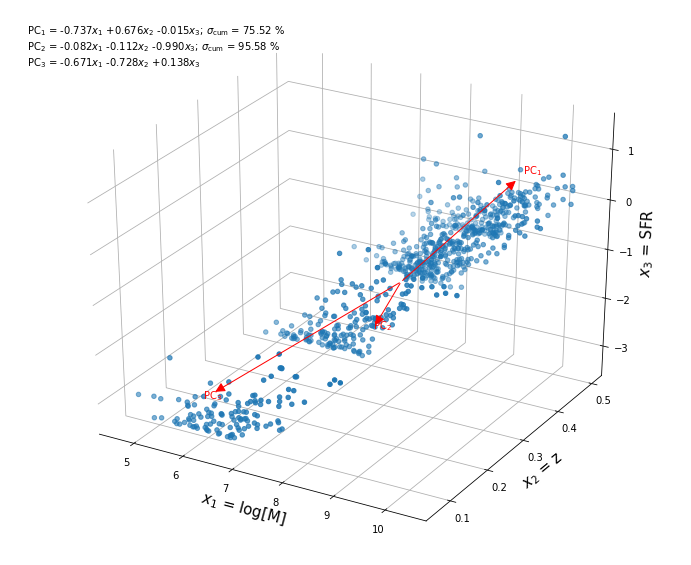

In [17]:
from mpl_toolkits.mplot3d import Axes3D, proj3d

fig = plt.figure()
fig.set_size_inches(12,10)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xData, yData, zData)
ax.set_xlabel(r'$x_1$ = '+labels[0], fontsize='15')
ax.set_ylabel(r'$x_2$ = '+labels[1], fontsize='15')
ax.set_zlabel(r'$x_3$ = '+labels[2], fontsize='15')
PCA_str = pca_str(evec, cum_var0=cum_var0)

for ii in range(evec.shape[0]):
    axis = evec[ii]

    xd = [mu[0], mu[0] + sigma * axis[0]]
    yd = [mu[1], mu[1] + sigma * axis[1]]
    zd = [mu[2], mu[2] + sigma * axis[2]]

    a = Arrow3D(xd, yd, zd, mutation_scale=20, lw=1, arrowstyle="-|>",
                color="r")
    ax.add_artist(a)

    xt = mu[0] + 1.05 * sigma * axis[0]
    yt = mu[1] + 1.05 * sigma * axis[1]
    zt = mu[2] + 1.05 * sigma * axis[2]
    ax.text(xt, yt, zt, r'PC$_'+str(ii+1)+'$', color='red')

ax.annotate(PCA_str, (0.025,0.975), xycoords='axes fraction',
                ha='left', va='top')


for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
    axis.gridlines.set_linestyle('dashed')
    axis.set_pane_color((1,1,1,1)) # White background
    axis.gridlines.set_color((0,0,0,1)) # Black grid

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

# plt.scatter(xData, zData)

## mean :  [ 8.08473881 -1.23577965]
[[-0.73946155 -0.67319879]
 [-0.67319879  0.73946155]]
[ 79.06101965 100.        ]


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:77: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


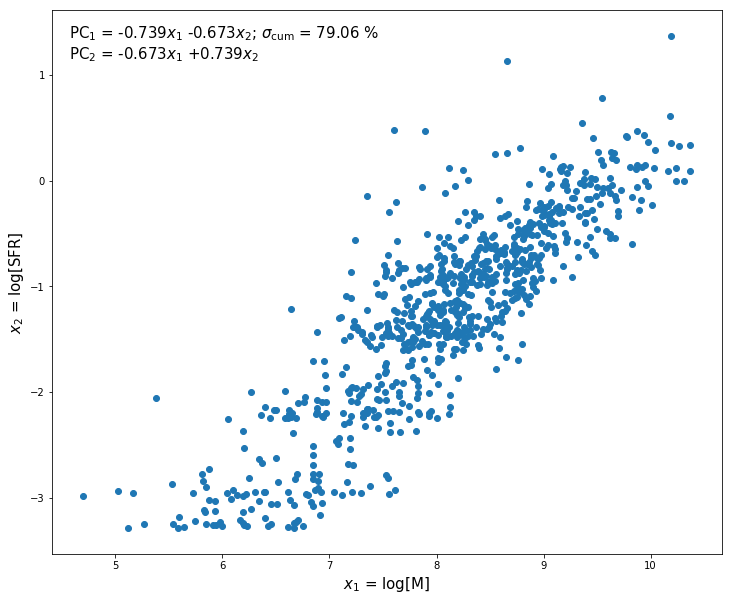

In [19]:
n_sample = len(xarr)
labels = ['log[M]', 'log[SFR]']

xData = np.copy(xarr) # log[M]
zData = np.copy(yarr) # log[SFR]

xData0 = np.reshape(xData, (len(xData),1))
zData0 = np.reshape(zData, (len(zData),1))

data = np.hstack((xData0, zData0))
mu = data.mean(axis=0)
print '## mean : ', mu
data = data - mu
evec, eval0, V = np.linalg.svd(data.T, full_matrices=False)
cum_var0 = cum_var(eval0) # + on 25/07/2016
projected_data0 = np.dot(data, evec)
sigma = projected_data0.std(axis=0).mean()

print evec
print cum_var0

# fig, ax = plt.figure()
# fig.set_size_inches(12,10)

plt.scatter(xData, zData)
plt.xlabel(r'$x_1$ = '+labels[0], fontsize='15')
plt.ylabel(r'$x_2$ = '+labels[1], fontsize='15')
PCA_str = pca_str(evec, cum_var0=cum_var0)

for ii in range(evec.shape[0]):
    axis = evec[ii]

    xd = [mu[0], mu[0] + sigma * axis[0]]
    yd = [mu[1], mu[1] + sigma * axis[1]]
#     zd = [mu[2], mu[2] + sigma * axis[2]]

#     a = Arrow3D(xd, yd, mutation_scale=20, lw=1, arrowstyle="-|>",
#                 color="r")

#     a = Arrow3D(xd, yd, zd, mutation_scale=20, lw=1, arrowstyle="-|>",
#                 color="r")
#     ax.add_artist(a)

    xt = mu[0] + 1.05 * sigma * axis[0]
    yt = mu[1] + 1.05 * sigma * axis[1]
#     zt = mu[2] + 1.05 * sigma * axis[2]
#     ax.text(xt, yt, zt, r'PC$_'+str(ii+1)+'$', color='red')

plt.annotate(PCA_str, (0.025,0.975), xycoords='axes fraction',
                ha='left', va='top', fontsize=15)

plt.gcf().set_size_inches(12,10)

In [20]:
import scipy.optimize as optimize
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import ascii as asc

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0

In [21]:
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                Reader=asc.FixedWidthTwoLine)
zspec0 = np.array(corr_tbl['zspec0'])

fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.GALEX.fout',
                 guess=False,Reader=asc.NoHeader)
stlr_mass = np.array(fout['col7'])

filts = np.array(corr_tbl['filt'])

# defining a flux sigma cutoff
good_sig_iis = np.where(corr_tbl['flux_sigma'] >= CUTOFF_SIGMA)[0]

obs_sfr = np.array(corr_tbl['obs_sfr'])
dust_corr_factor = np.array(corr_tbl['dust_corr_factor'])
filt_corr_factor = np.array(corr_tbl['filt_corr_factor'])
nii_ha_corr_factor = np.array(corr_tbl['nii_ha_corr_factor'])
corrs = filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

ffs = filts[good_sig_iis]

zspec0 = np.array(corr_tbl['zspec0'])[good_sig_iis]
smass0 = stlr_mass[corr_tbl['ID'].data-1][good_sig_iis]

badz_iis = np.array([x for x in range(len(zspec0)) if zspec0[x] < 0 or zspec0[x] > 9])
filt_lambda_list = {'NB704':7045.0, 'NB711':7126.0, 'NB816':8152.0, 'NB921':9193.0, 'NB973':9749.0}

for ff in filt_lambda_list.keys():
    badf_match = np.where(ffs[badz_iis] == ff)[0]
    zspec0[badz_iis[badf_match]] = (filt_lambda_list[ff]/6562.8) - 1
    
sfrs00 = obs_sfr[good_sig_iis]+corrs[good_sig_iis]

In [22]:
data00 = np.vstack([smass0, zspec0]).T

In [23]:
"""
data[:,0] = log[M]
data[:,1] = redshift

Usage:
params, pcov = optimize.curve_fit(func, A[:,:2], A[:,2], guess)
o The first argument to curve_fit is the function.
o The second argument is the independent data (x and y in the form of one array).
o The third argument is the dependent data (z).
o The fourth argument is a guess for the value of the parameters (a and b in this case.)
"""
eqn0 = r'$log[SFR] = a*log[M] + b*z + c$'
def func0(data, a, b, c):
    return a*data[:,0] + b*data[:,1] + c

eqn1 = r'$log[SFR] = a*log[M] + b*(1+z) + c$'
def func1(data, a, b, c):
    return a*data[:,0] + b*(1+data[:,1]) + c

eqn2 = r'$log[SFR] = a*log[M] + (z)^{b} + c$'
def func2(data, a, b, c):
    return a*data[:,0] + (data[:,1])**b + c

eqn3 = r'$log[SFR] = a*log[M] + (1+z)^{b} + c$'
def func3(data, a, b, c):
    return a*data[:,0] + (1+data[:,1])**b + c

eqn4 = r'$log[SFR] = a*log[M] + b*\log(1+z) + c$'
def func4(data, a, b, c):
    return a*data[:,0] + np.log10(1+data[:,1]) + c

## method='lm'

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*(1+z) + c$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$


//anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


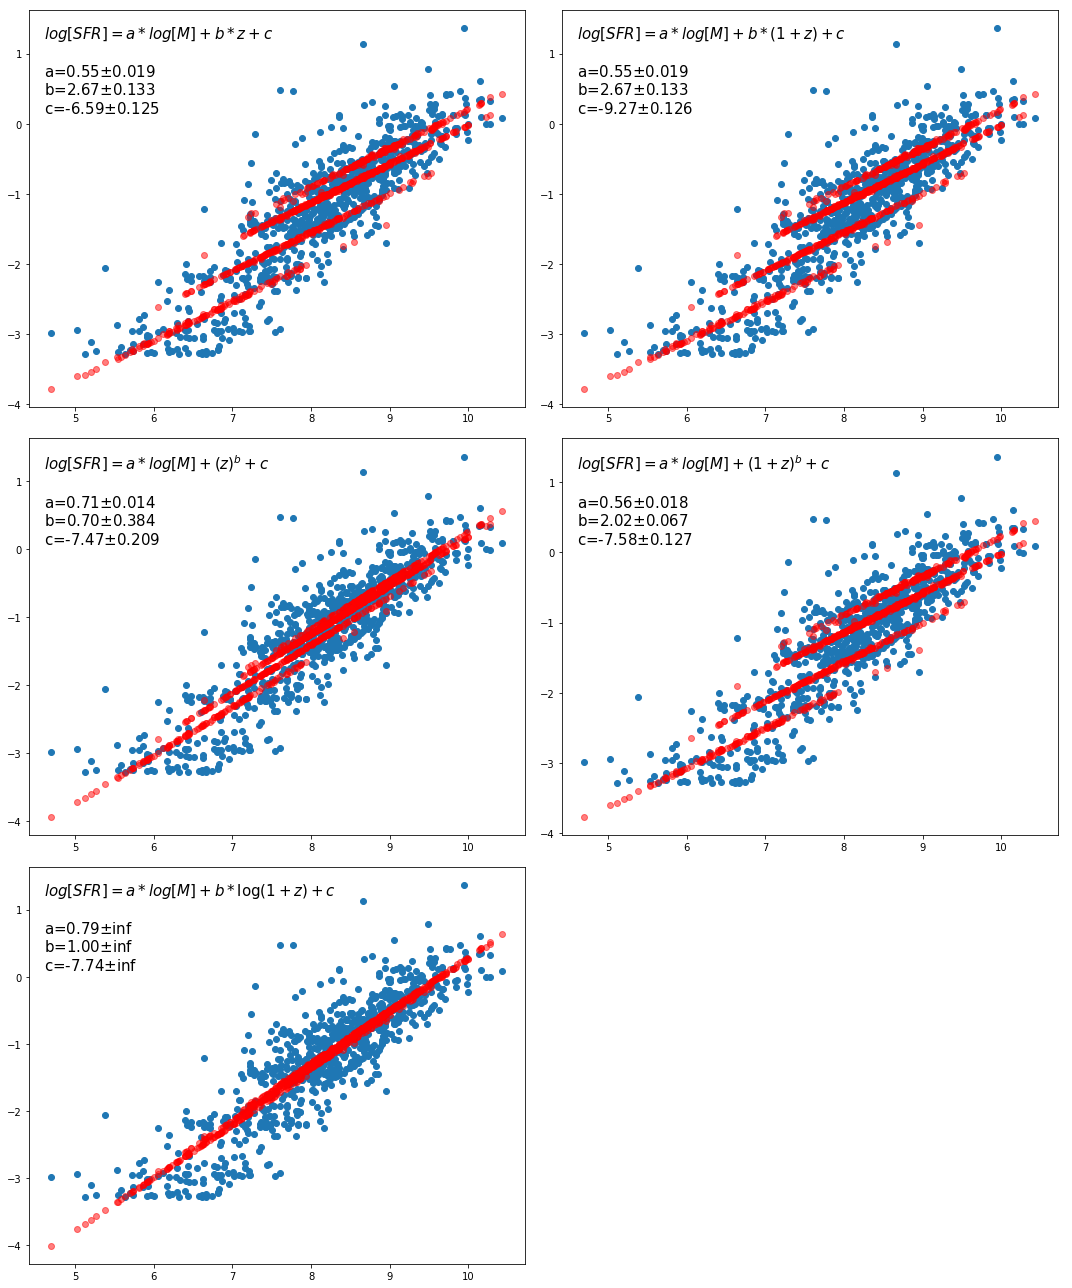

In [24]:
f, axes = plt.subplots(3,2)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4], [eqn0, eqn1, eqn2, eqn3, eqn4]):
    print eqn_str
    params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='lm')
    perr = np.sqrt(np.diag(pcov))
    
    ax.plot(smass0, sfrs00, 'o')
    ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
    ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')

axarr[-1].set_axis_off()
f.set_size_inches(15,18)
f.tight_layout()

## method='trf'

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*(1+z) + c$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$


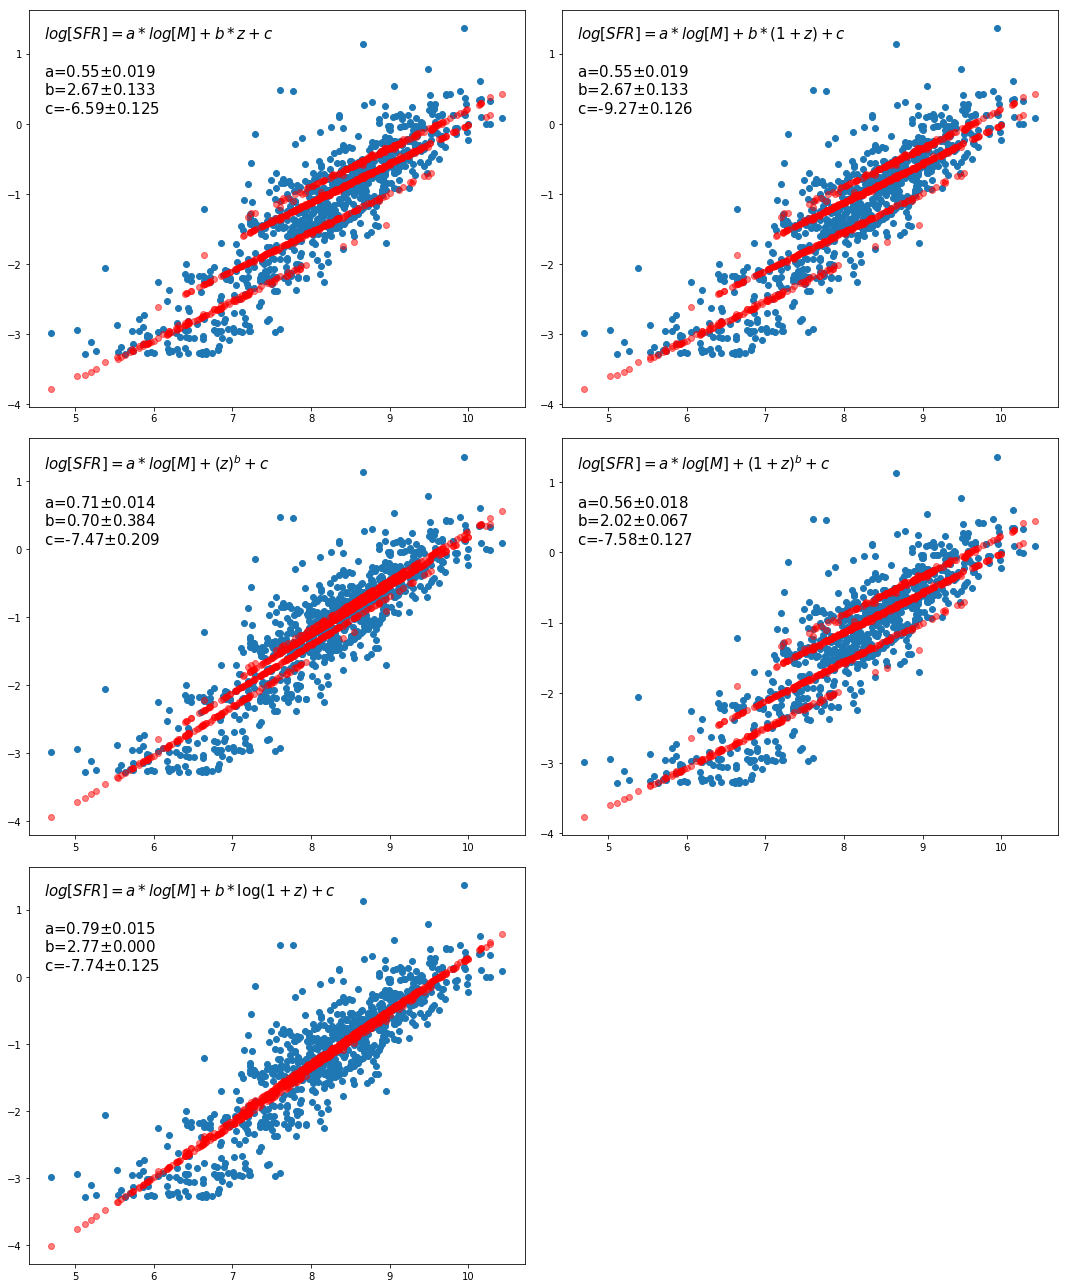

In [25]:
f, axes = plt.subplots(3,2)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4], [eqn0, eqn1, eqn2, eqn3, eqn4]):
    print eqn_str
    params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='trf')
    perr = np.sqrt(np.diag(pcov))
    
    ax.plot(smass0, sfrs00, 'o')
    ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
    ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')

axarr[-1].set_axis_off()
f.set_size_inches(15,18)
f.tight_layout()

## method='dogbox'

$log[SFR] = a*log[M] + b*z + c$
$log[SFR] = a*log[M] + b*(1+z) + c$
$log[SFR] = a*log[M] + (z)^{b} + c$
$log[SFR] = a*log[M] + (1+z)^{b} + c$
$log[SFR] = a*log[M] + b*\log(1+z) + c$


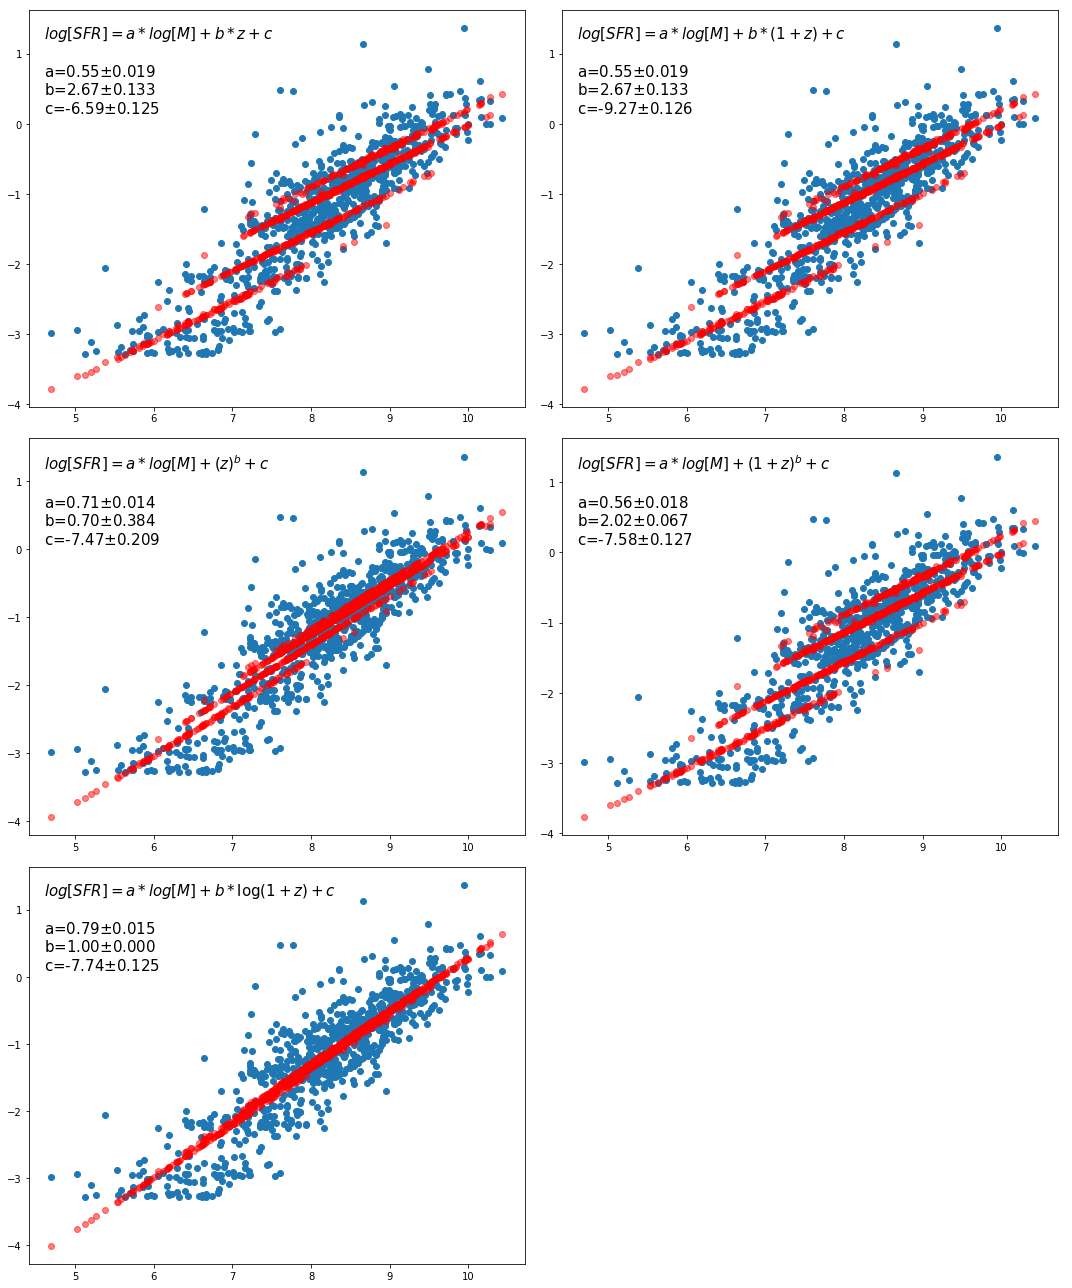

In [26]:
f, axes = plt.subplots(3,2)
axarr = np.ndarray.flatten(axes)

guess = (0.8,1, -7)
for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3, func4], [eqn0, eqn1, eqn2, eqn3, eqn4]):
    print eqn_str
    params, pcov = optimize.curve_fit(func, data00, sfrs00, guess, method='dogbox')
    perr = np.sqrt(np.diag(pcov))
    
    ax.plot(smass0, sfrs00, 'o')
    ax.plot(smass0, func(data00, *params), 'ro', alpha=0.5)
    ax.text(0.03,0.97,eqn_str+
            '\n\na='+'{:.2f}'.format(params[0])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[0])+
            '\nb='+'{:.2f}'.format(params[1])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[1])+
            '\nc='+'{:.2f}'.format(params[2])+r'$\pm$'+'{:.3f}'.format(np.sqrt(np.diag(pcov))[2]),
            transform=ax.transAxes,fontsize=15,ha='left',va='top')

axarr[-1].set_axis_off()
f.set_size_inches(15,18)
f.tight_layout()